# Installs & Imports

In [1]:
!pip install -q librosa soundata optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from librosa import display
import soundata
import tensorflow as tf
import keras
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve, auc, average_precision_score,
    precision_recall_curve, cohen_kappa_score, matthews_corrcoef
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

import optuna

import os
import sys
import shutil
import random
import joblib
import pickle
from tqdm.notebook import tqdm
from IPython import display as ipd
from collections import Counter, defaultdict

In [3]:
# Get versions
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Librosa version: {librosa.__version__}")
print(f"Soundata version: {soundata.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Optuna version: {optuna.__version__}")

Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
NumPy version: 1.25.2
Pandas version: 1.5.3
Matplotlib version: 3.7.1
Seaborn version: 0.13.1
Librosa version: 0.10.1
Soundata version: 0.1.3
TensorFlow version: 2.15.0
Keras version: 2.15.0
Scikit-learn version: 1.2.2
Optuna version: 3.5.0


# Loading the Data

In [4]:
# Load the data
dataset = soundata.initialize('urbansound8k')
dataset.download()
dataset.validate()

example_clip = dataset.choice_clip()
print(example_clip)

5.61GB [04:16, 23.4MB/s]                            
100%|██████████| 8732/8732 [00:14<00:00, 583.56it/s]

Clip(
  audio_path="/root/sound_datasets/urbansound8k/audio/fold1/180937-7-3-11.wav",
  clip_id="180937-7-3-11",
  audio: The clip's audio
            * np.ndarray - audio signal
            * float - sample rate,
  class_id: The clip's class id.
            * int - integer representation of the class label (0-9). See Dataset Info in the documentation for mapping,
  class_label: The clip's class label.
            * str - string class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music,
  fold: The clip's fold.
            * int - fold number (1-10) to which this clip is allocated. Use these folds for cross validation,
  freesound_end_time: The clip's end time in Freesound.
            * float - end time in seconds of the clip in the original freesound recording,
  freesound_id: The clip's Freesound ID.
            * str - ID of the freesound.org recording from which this clip was taken,
  freesound_start_time:

In [59]:
# Function to get random audio clip for each class
def get_random_audio_clips(dataset):
    # Initialize a dictionary to hold clip IDs for each class
    clips_per_class = defaultdict(list)
    for clip_id in dataset.clip_ids:
        clip = dataset.clip(clip_id)
        clips_per_class[clip.class_label].append(clip_id)

    # Select a random clip ID for each class label
    selected_clip_ids = {class_label: random.choice(clip_ids) for class_label, clip_ids in clips_per_class.items()}

    # Get audio for each selected clip
    for class_label, clip_id in selected_clip_ids.items():
        clip = dataset.clip(clip_id)
        audio, sr = clip.audio

        print(f"Sample for class: {class_label}")
        ipd.display(ipd.Audio(audio, rate=sr))
        print('=' * 50)

# Call the function
get_random_audio_clips(dataset)

Sample for class: children_playing


Sample for class: gun_shot


Sample for class: air_conditioner


Sample for class: jackhammer


Sample for class: drilling


Sample for class: engine_idling


Sample for class: dog_bark


Sample for class: siren


Sample for class: street_music


Sample for class: car_horn


# Exploring the Data

In [60]:
# Number of samples
num_samples = len(dataset.clip_ids)
print(f"There are {num_samples} samples in the dataset.")

There are 8732 samples in the dataset.


In [61]:
# Number of classes
class_labels = [dataset.clip(clip_id).class_label for clip_id in dataset.clip_ids]
num_classes = len(set(class_labels))
print(f"There are {num_classes} classes in the dataset.")

There are 10 classes in the dataset.


In [62]:
# Class distribution
class_distribution = Counter(class_labels)

# Convert to DataFrame
class_dist_df = pd.DataFrame.from_dict(class_distribution, orient='index')
class_dist_df.columns = ['Count']
class_dist_df = class_dist_df.sort_values(by='Count', ascending=False)
class_dist_df

Count
children_playing   1000
air_conditioner    1000
jackhammer         1000
drilling           1000
engine_idling      1000
dog_bark           1000
street_music       1000
siren               929
car_horn            429
gun_shot            374

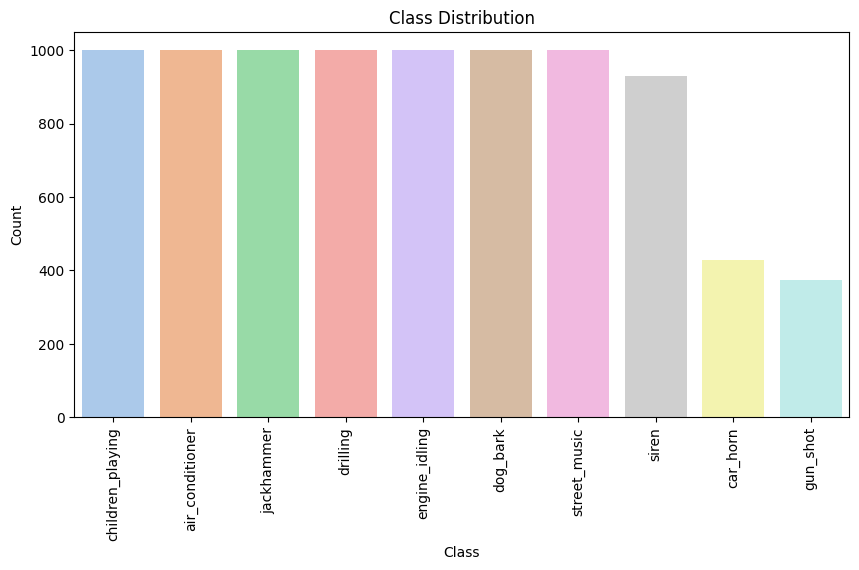

In [63]:
# Plot the distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=class_dist_df.index, y='Count', hue=class_dist_df.index, data=class_dist_df, palette=sns.color_palette('pastel', num_classes))
plt.title('Class Distribution')
plt.ylabel('Count')
plt.xlabel('Class')
plt.xticks(rotation=90)
plt.show()

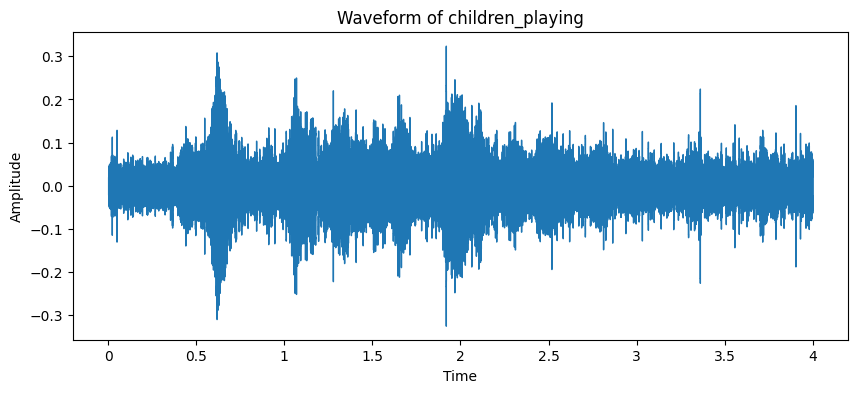

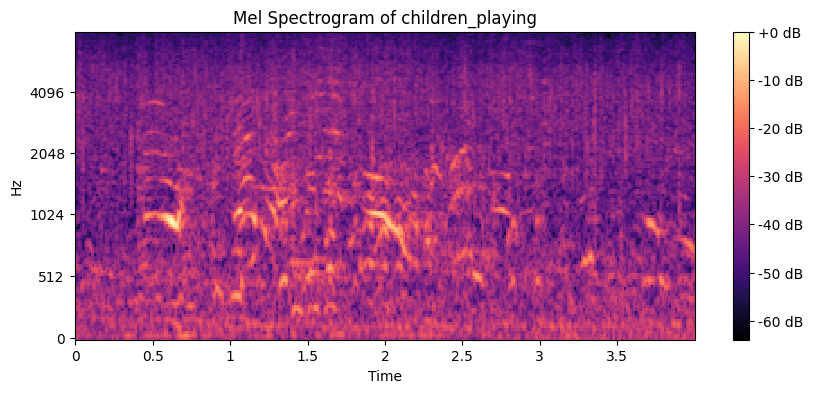

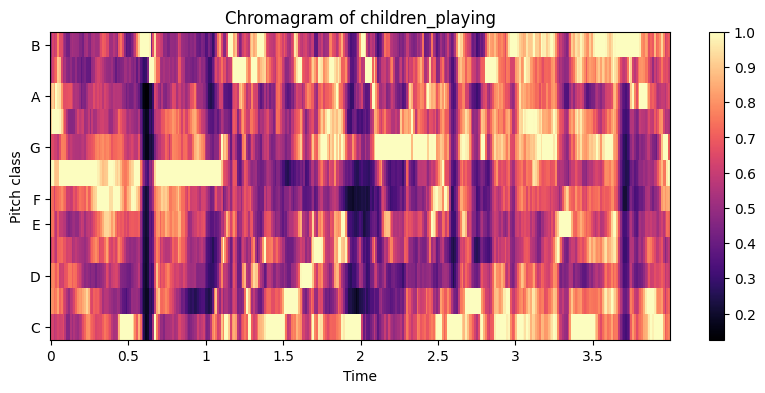

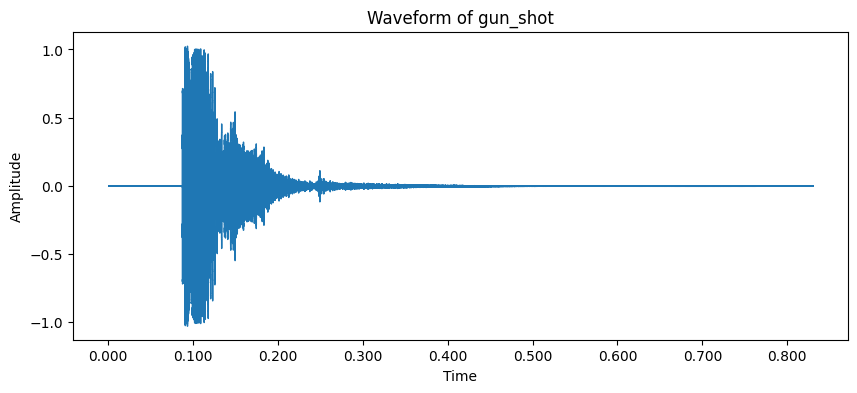

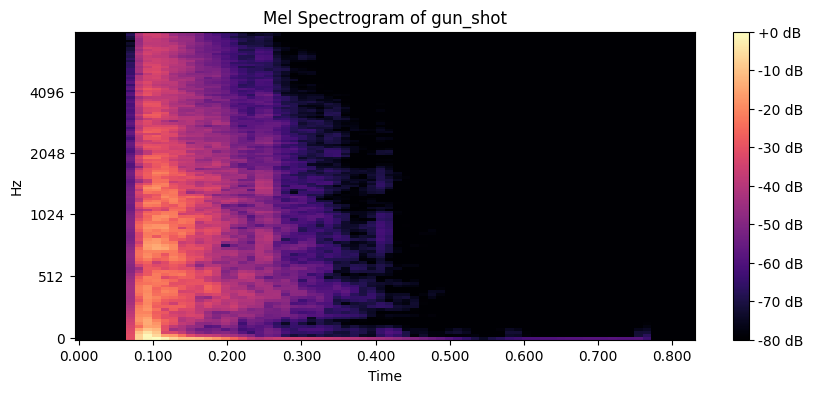

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=572
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=286
  warnings.warn(


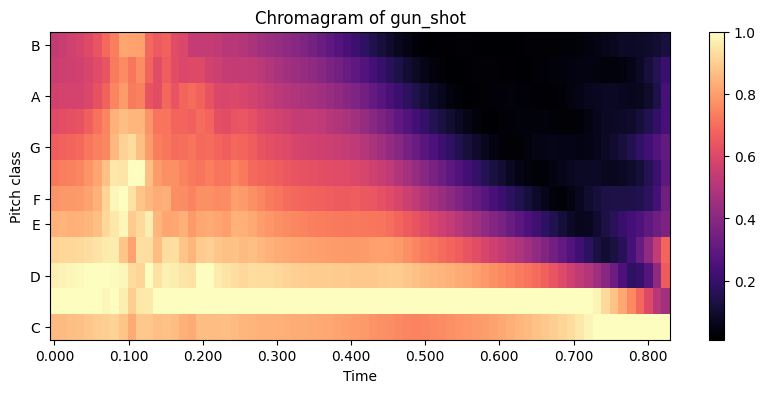

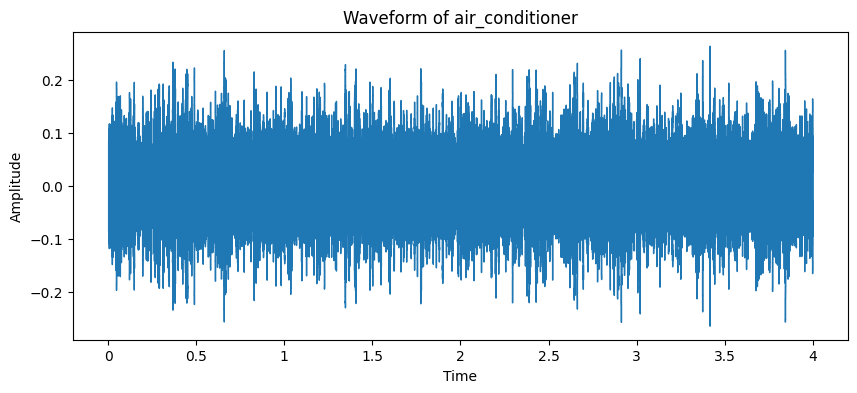

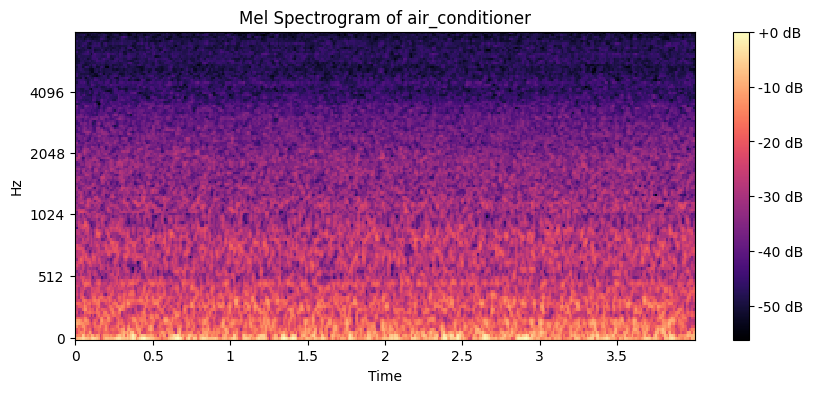

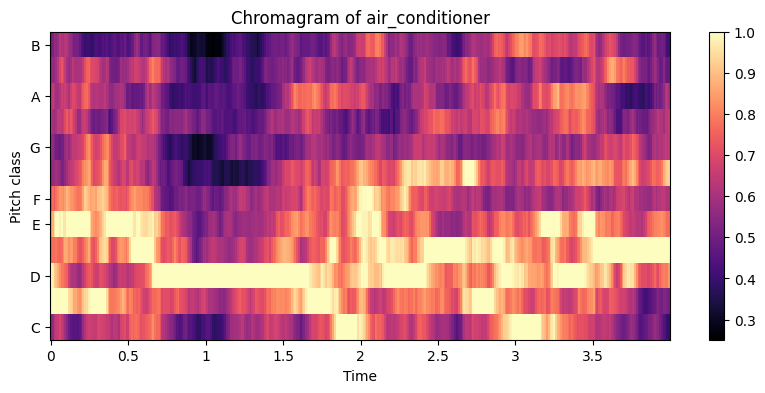

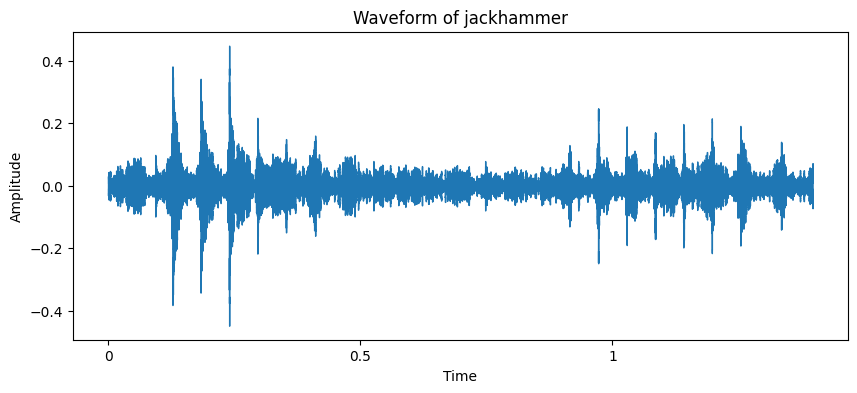

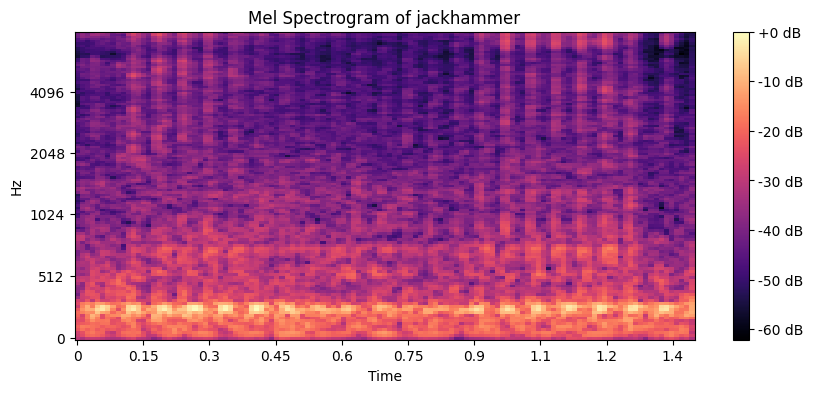

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=963
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=482
  warnings.warn(


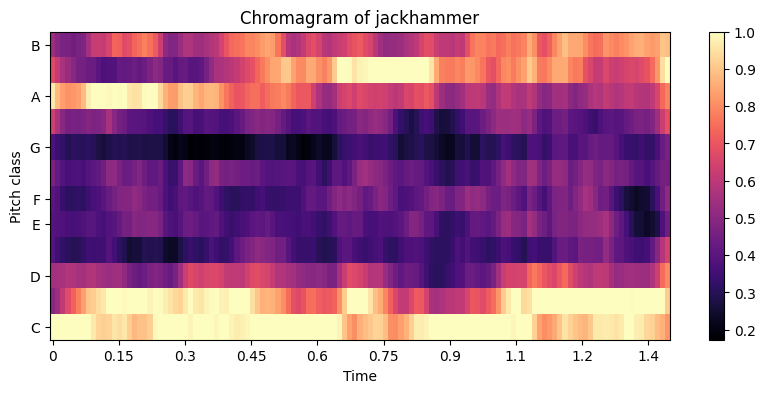

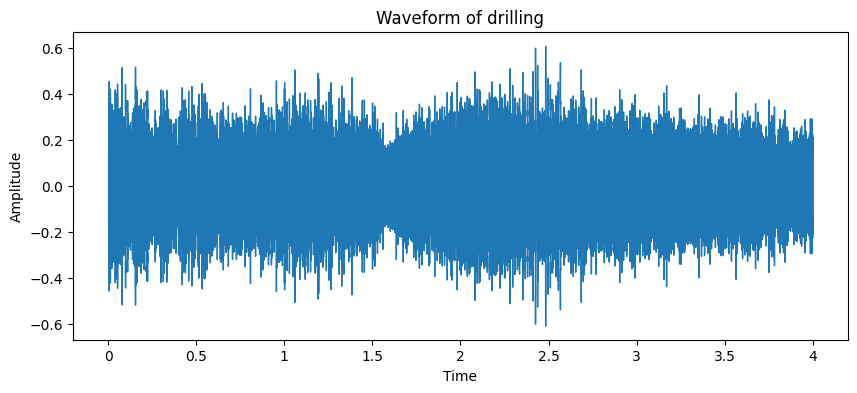

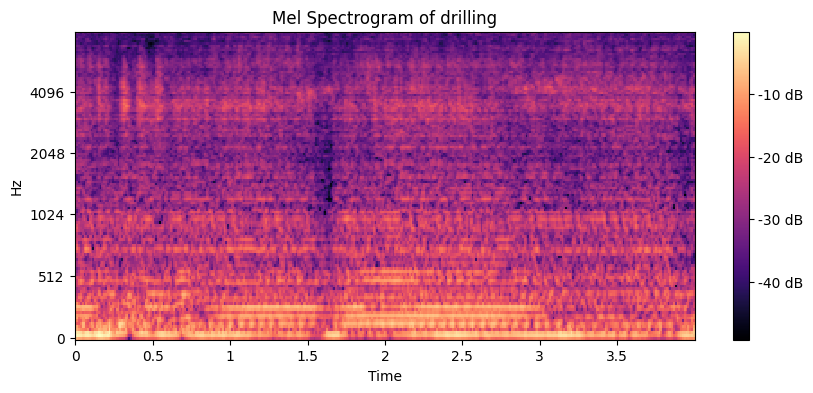

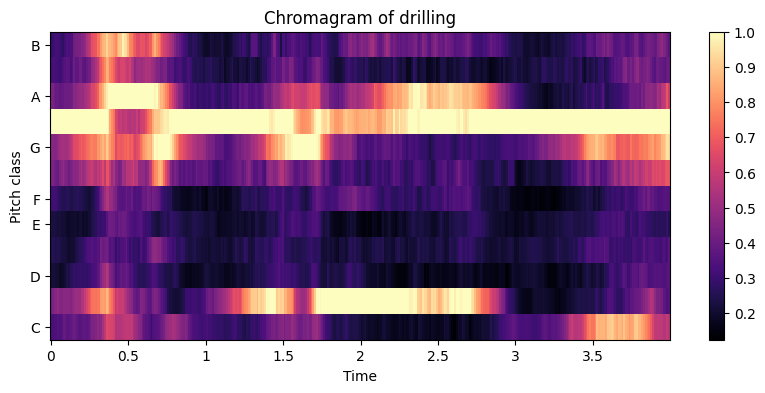

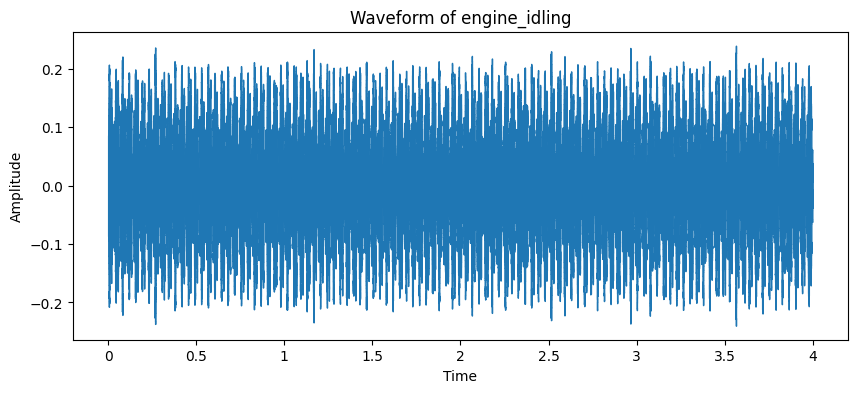

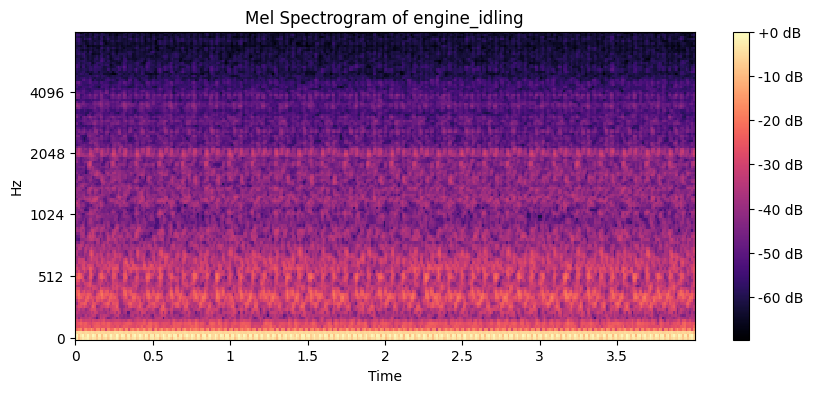

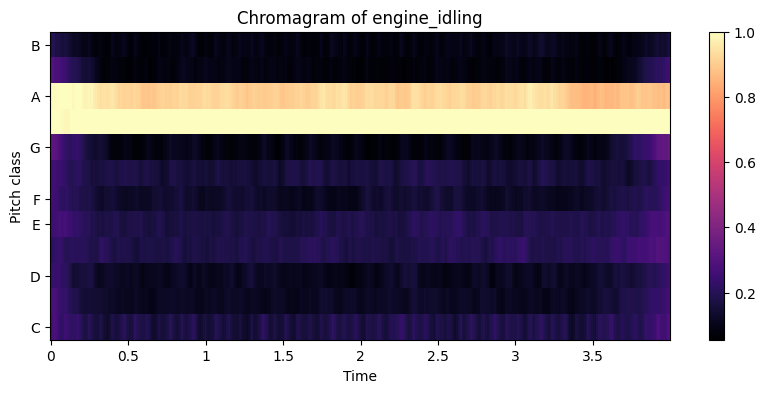

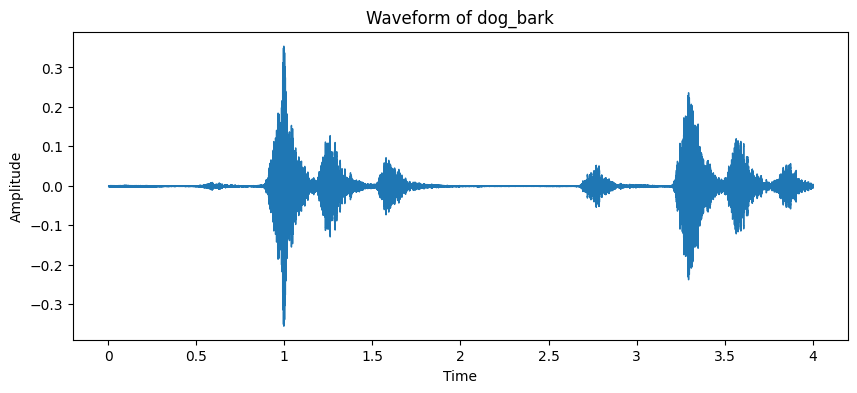

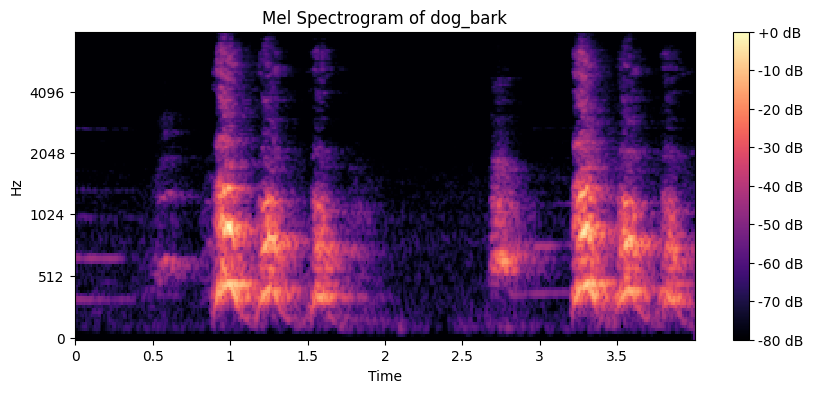

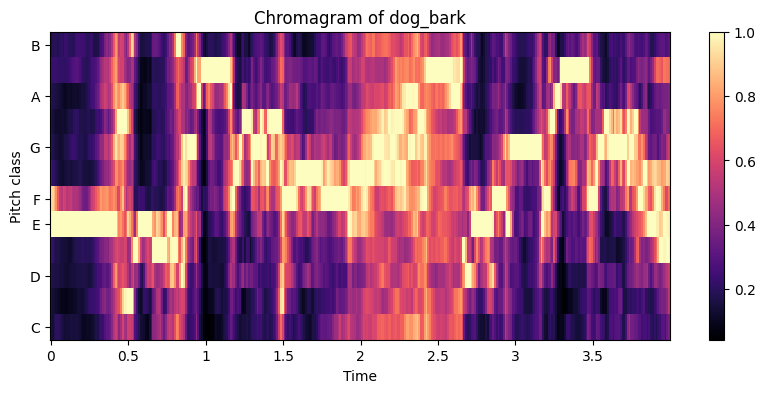

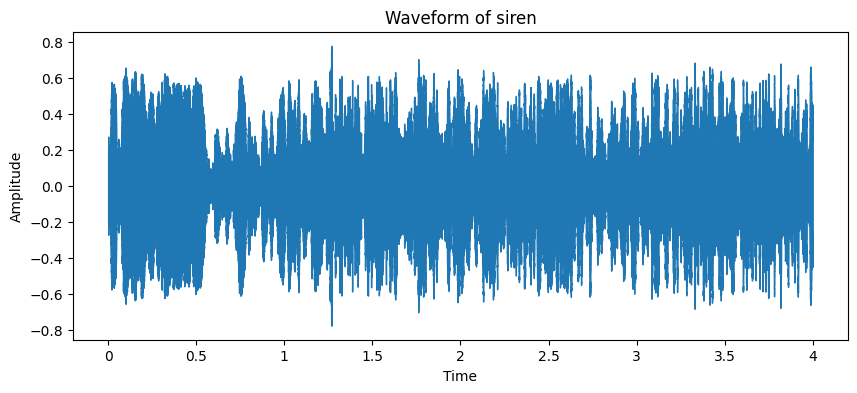

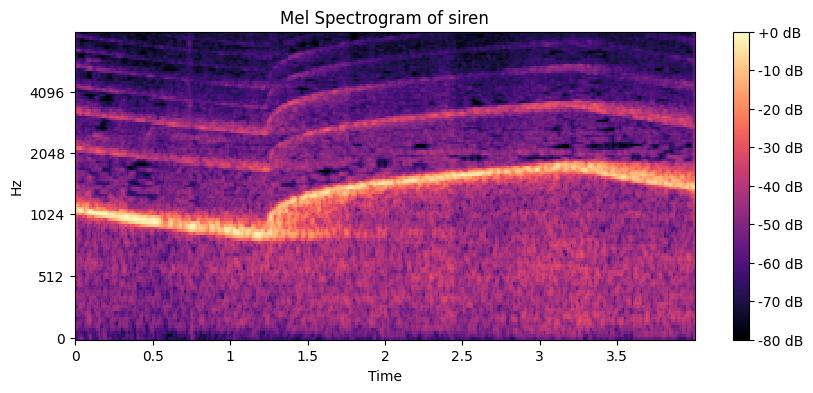

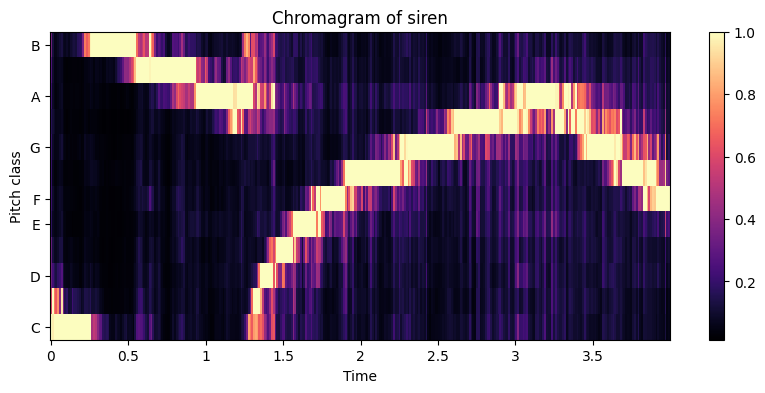

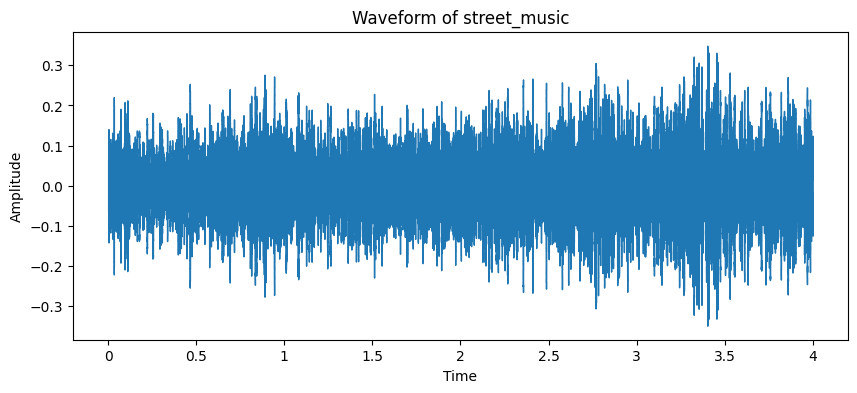

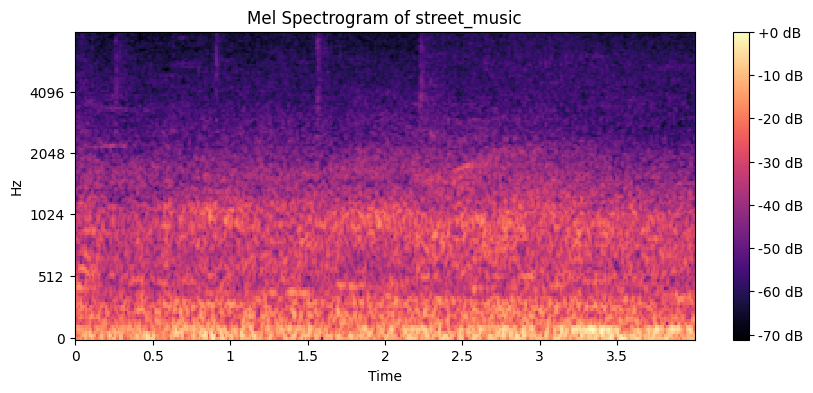

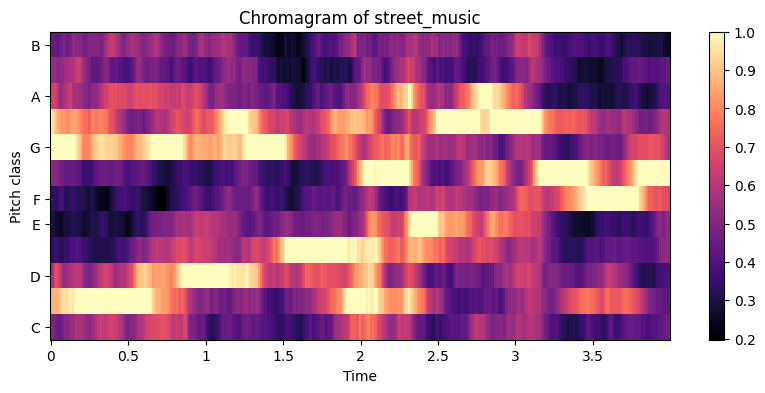

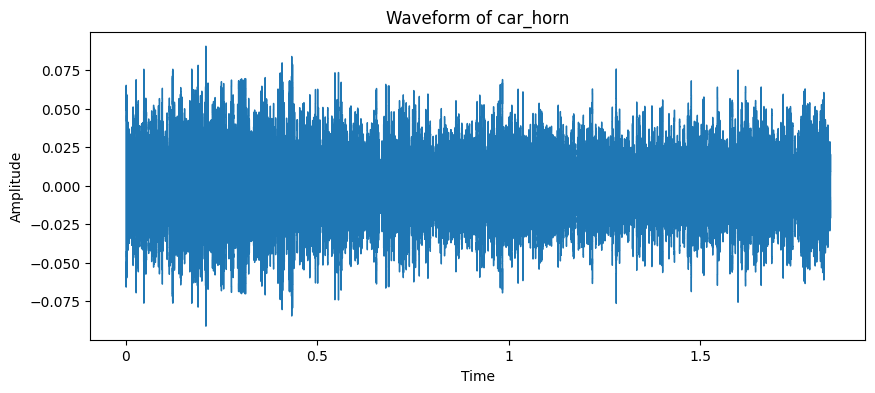

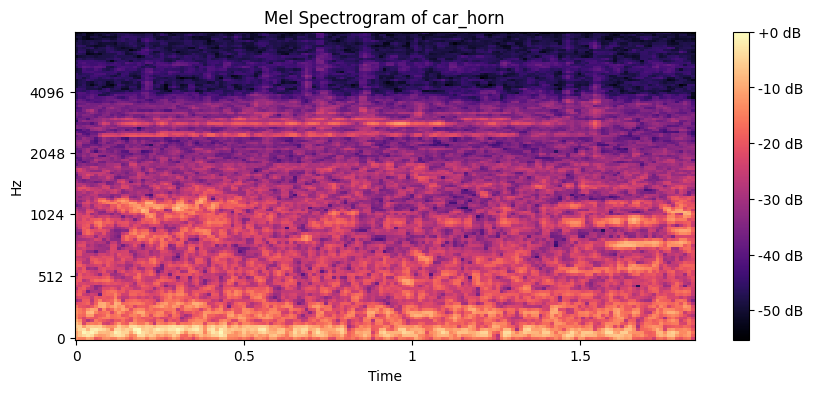

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=634
  warnings.warn(


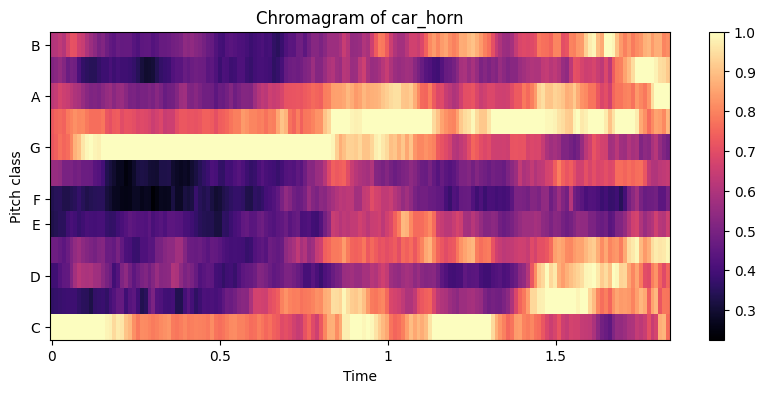

In [64]:
# Function to visualize the audio samples
def visualize_audio_samples(dataset):
    # Initialize a dictionary to hold clip IDs for each class label
    clips_per_class = defaultdict(list)
    for clip_id in dataset.clip_ids:
        clip = dataset.clip(clip_id)
        clips_per_class[clip.class_label].append(clip_id)

    # Select a random clip ID for each class label
    selected_clip_ids = {class_label: random.choice(clip_ids) for class_label, clip_ids in clips_per_class.items()}

    # Visualize waveform, Mel spectrogram, and Chromagram for each selected clip
    for class_label, clip_id in selected_clip_ids.items():
        clip = dataset.clip(clip_id)
        audio, sr = clip.audio

        # Plot waveform
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(audio, sr=sr)
        plt.title(f'Waveform of {class_label}')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.show()

        # Compute and plot Mel spectrogram
        S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
        S_DB = librosa.power_to_db(S, ref=np.max)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram of {class_label}')
        plt.show()

        # Compute and plot Chromagram
        chroma = librosa.feature.chroma_cqt(y=audio, sr=sr)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', sr=sr)
        plt.colorbar()
        plt.title(f'Chromagram of {class_label}')
        plt.show()

        print('=' * 90)

# Call the function
visualize_audio_samples(dataset)

# Preprocessing the Data

## Extract Features

In [65]:
# Function to pad the audio if necessary
def pad_audio_to_length(audio, target_length, sr):
    current_length = len(audio)
    target_length_samples = int(target_length * sr)

    if current_length < target_length_samples:
        # Calculate the number of samples to pad
        pad_length = target_length_samples - current_length
        padded_audio = np.pad(audio, (0, pad_length), mode='constant')
    else:
        padded_audio = audio

    return padded_audio

In [66]:
# Function to resample, pad, extract features, and binarize labels
def extract_features(dataset, target_sr=22050, n_fft=2048, hop_length=512, n_mfcc=13):
    features_list = []
    target_length = 4.0

    # Iterate through each clip in the dataset
    for clip_id in dataset.clip_ids:
        clip = dataset.clip(clip_id)
        audio, sr = clip.audio

        # Resample the audio to the target sampling rate if necessary
        if sr != target_sr:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
            sr = target_sr

        # Ensure audio is padded to the target length
        audio = pad_audio_to_length(audio, target_length, sr)

        # Extract features
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfccs_mean = np.mean(mfccs, axis=1)
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio, hop_length=hop_length))
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length))
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length), axis=1)
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length), axis=1)
        mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length))

        onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
        attack_time = np.argmax(onset_env) * hop_length / sr
        decay_time = len(audio) / sr - attack_time

        # Combine all features into a single vector
        features_vector = np.concatenate([
            mfccs_mean,
            [zcr, spectral_centroid, spectral_rolloff, mel_spectrogram],
            spectral_contrast,
            chroma,
            [attack_time, decay_time]
        ])
        features_list.append({'features': features_vector, 'label': 1 if clip.class_label == 'gun_shot' else 0})

    return features_list

# Call the function
features_data = extract_features(dataset)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [67]:
# Save the features data to a file
with open('features_data.pkl', 'wb') as file:
    pickle.dump(features_data, file)

In [5]:
# Load the features data from the file
with open('features_data.pkl', 'rb') as file:
    features_data = pickle.load(file)

In [6]:
# Create feature names
n_mfcc = 13
n_chroma = 12
n_spectral_contrast = 7

mfcc_feature_names = [f"MFCC_{i+1}" for i in range(n_mfcc)]
spectral_contrast_feature_names = [f"SpectralContrast_{i+1}" for i in range(n_spectral_contrast)]
chroma_feature_names = [f"Chroma_{i+1}" for i in range(n_chroma)]
single_value_feature_names = ['ZCR', 'SpectralCentroid', 'SpectralRolloff', 'MelSpectrogram', 'AttackTime', 'DecayTime']

feature_names = mfcc_feature_names + single_value_feature_names + spectral_contrast_feature_names + chroma_feature_names

In [7]:
# Set columns to maximum
pd.set_option('display.max_columns', None)

# Prepare data for DataFrame creation
data_for_df = []

for item in features_data:
    features_dict = {f_name: f_val for f_name, f_val in zip(feature_names, item['features'])}
    features_dict['Label'] = item['label']
    data_for_df.append(features_dict)

# Create DataFrame
features_df = pd.DataFrame(data_for_df)

# Display the DataFrame
features_df.head()

MFCC_1      MFCC_2     MFCC_3     MFCC_4     MFCC_5     MFCC_6  \
0 -360.428711  101.799385 -48.452560  19.529387 -38.798157  -2.762234   
1 -514.698181   26.070553 -39.440971  15.977687 -11.840044   4.835781   
2 -195.779236   71.543922 -21.708836  53.107872  25.810648  17.948709   
3 -192.423386  179.148453   2.353148   5.435854  -2.074950  -4.626775   
4 -253.106689   31.868446  -7.825550  23.297758  -4.329890  19.634998   

      MFCC_7     MFCC_8     MFCC_9    MFCC_10    MFCC_11    MFCC_12  \
0 -19.598938  -0.748570  -9.297232   0.005592  -6.235853   3.855452   
1  -8.802161   1.941157  -4.388472  -1.307502  -3.835765   0.452041   
2   5.881225   9.549773  -3.258073  10.100700  19.029978  -1.886575   
3 -12.023396   7.782510 -15.510917  -0.380375  -9.807850  -6.300093   
4  -9.299934  16.484146  -7.474760   8.338264   2.456118  12.483587   

     MFCC_13       ZCR  SpectralCentroid  SpectralRolloff  MelSpectrogram  \
0  -7.079578  0.131294       2157.843464      4073.260533        0.015638   
1  -0.429392  0.060538        824.628926      1333.378257        0.650767   
2   8.154268  0.096132       2237.854886      4577.859409        0.660452   
3 -20.871683  0.038470        901.999151      1362.877501        2.341649   
4  -2.474160  0.181787       2719.328313      5101.999977        0.454015   

   AttackTime  DecayTime  SpectralContrast_1  SpectralContrast_2  \
0   33.600283  14.510648           18.314453           19.189440   
1    8.434165   7.026992            7.455770            7.543952   
2   15.804524  10.413192           13.944489           15.547130   
3   25.592470  11.025404           14.647796           15.159430   
4   18.514591  12.685586           13.820820           14.145793   

   SpectralContrast_3  SpectralContrast_4  SpectralContrast_5  \
0           18.897433           19.316690           52.272584   
1            7.961006           11.518813           21.385842   
2           15.943534           18.985393           43.743110   
3           16.767774           16.237821           46.456960   
4           14.695049           15.709661           43.256920   

   SpectralContrast_6  SpectralContrast_7  Chroma_1  Chroma_2  Chroma_3  \
0            0.302249            0.370210  0.398669  0.403678  0.409805   
1            0.250509            0.256086  0.210101  0.168845  0.148668   
2            0.519965            0.466049  0.493235  0.552868  0.601802   
3            0.351737            0.308191  0.305249  0.369529  0.509951   
4            0.528077            0.494636  0.503364  0.519524  0.636063   

   Chroma_4  Chroma_5  Chroma_6  Chroma_7  Chroma_8  Chroma_9  Chroma_10  \
0  0.419761  0.520074  0.399364  0.333400  0.209773  0.230499   0.236642   
1  0.137492  0.140484  0.152970  0.168971  0.159580  0.178737   0.233685   
2  0.772894  0.809187  0.684383  0.541798  0.451651  0.463271   0.506475   
3  0.741404  0.819406  0.623610  0.527260  0.501138  0.454938   0.413126   
4  0.580882  0.457143  0.429452  0.443312  0.460302  0.460294   0.529355   

   Chroma_11  Chroma_12  Label  
0   2.345215   1.654785      0  
1   0.069660   3.930340      1  
2   0.325079   3.674921      0  
3   0.069660   3.930340      0  
4   0.069660   3.930340      0

In [8]:
# Examine shapes
features_df.shape

(8732, 39)

## Split the Data

In [9]:
# Split the data into features and labels
X = np.array([sample['features'] for sample in features_data])
y = np.array([sample['label'] for sample in features_data])

In [10]:
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

## Normalize the Data

In [11]:
# Scale the features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Select Features

In [12]:
# Initialize the classifier
estimator = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')

# Initialize RFECV
min_features_to_select = 1
cv_strategy = StratifiedKFold(n_splits=5)

rfecv = RFECV(estimator=estimator, step=1, cv=cv_strategy, scoring='f1_weighted', min_features_to_select=min_features_to_select)

# Fit and transform
X_train_selected = rfecv.fit_transform(X_train_scaled, y_train)
X_val_selected = rfecv.transform(X_val_scaled)
X_test_selected = rfecv.transform(X_test_scaled)

In [13]:
# Examine selected features
selected_features_indices = rfecv.get_support(indices=True)
selected_feature_names = [feature_names[i] for i in selected_features_indices]

# Determine eliminated features
all_feature_indices = set(range(len(feature_names)))
eliminated_features_indices = list(all_feature_indices - set(selected_features_indices))
eliminated_feature_names = [feature_names[i] for i in eliminated_features_indices]

print(f"Selected Feature Names: {selected_feature_names}")
print(f"Eliminated Feature Names: {eliminated_feature_names}")

Selected Feature Names: ['MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13', 'ZCR', 'SpectralCentroid', 'SpectralRolloff', 'MelSpectrogram', 'AttackTime', 'DecayTime', 'SpectralContrast_1', 'SpectralContrast_2', 'SpectralContrast_3', 'SpectralContrast_4', 'SpectralContrast_5', 'SpectralContrast_6', 'SpectralContrast_7', 'Chroma_1', 'Chroma_2', 'Chroma_3', 'Chroma_4', 'Chroma_5', 'Chroma_6', 'Chroma_7', 'Chroma_8', 'Chroma_9', 'Chroma_10', 'Chroma_11', 'Chroma_12']
Eliminated Feature Names: []


In [14]:
# Access the mean test score for each number of selected features
mean_scores = rfecv.cv_results_['mean_test_score']

# Number of features tested
n_features = [i for i in range(1, len(mean_scores) + 1)]

print("Number of Features | Mean CV Score")
print("-----------------------------------")
for n, score in zip(n_features, mean_scores):
    print(f"{n:>17} | {score:.5f}")

Number of Features | Mean CV Score
-----------------------------------
                1 | 0.93630
                2 | 0.95917
                3 | 0.96117
                4 | 0.96786
                5 | 0.97463
                6 | 0.97613
                7 | 0.97721
                8 | 0.97968
                9 | 0.98222
               10 | 0.98210
               11 | 0.98120
               12 | 0.98389
               13 | 0.98341
               14 | 0.98429
               15 | 0.98536
               16 | 0.98500
               17 | 0.98531
               18 | 0.98646
               19 | 0.98650
               20 | 0.98744
               21 | 0.98668
               22 | 0.98638
               23 | 0.98718
               24 | 0.98664
               25 | 0.98690
               26 | 0.98595
               27 | 0.98743
               28 | 0.98696
               29 | 0.98682
               30 | 0.98806
               31 | 0.98732
               32 | 0.98744
               33 | 0.98779
     

## TensorFlow Datasets

In [15]:
# Set the batch size
BATCH_SIZE = 32

# Create TensorFlow Dataset objects
train_ds = tf.data.Dataset.from_tensor_slices((X_train_selected, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val_selected, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test_selected, y_test))

# Shuffle training set
train_ds = train_ds.shuffle(buffer_size=len(X_train_selected), reshuffle_each_iteration=True)

# Batch the datasets
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Training & Evaluation

In [16]:
# Function to build the model
def create_model(input_shape):
    model = keras.Sequential()

    # Define the input layer
    inputs = keras.Input(shape=(input_shape,))

    # First layer
    x = keras.layers.Dense(256, activation='relu')(inputs)
    x = keras.layers.Dropout(0.3)(x)

    # Second layer
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)

    # Third layer
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)

    # Output layer
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Recall(name='recall'), keras.metrics.Precision(name='precision')], optimizer='adam')

    return model

In [17]:
# Create the model
input_shape = X_train_selected.shape[1]
model = create_model(input_shape)

In [18]:
# Set up callbacks
checkpoint_path = 'best_model.tf'
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001, mode='min', verbose=1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1)

In [19]:
# Calculate class weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

class_weights = dict(zip(classes, weights))
print(f"Class weights: {class_weights}")

Class weights: {0: 0.5223601555489081, 1: 11.680602006688963}


In [20]:
# Set the number of epochs
EPOCHS = 100

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[model_checkpoint, reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/100
219/219 [==============================] - ETA: 0s - loss: 0.2466 - accuracy: 0.9337 - recall: 0.9097 - precision: 0.3842
Epoch 1: val_loss improved from inf to 0.23895, saving model to best_model.tf
219/219 [==============================] - 6s 10ms/step - loss: 0.2466 - accuracy: 0.9337 - recall: 0.9097 - precision: 0.3842 - val_loss: 0.2390 - val_accuracy: 0.9015 - val_recall: 1.0000 - val_precision: 0.3008 - lr: 0.0010
Epoch 2/100
217/219 [============================>.] - ETA: 0s - loss: 0.1047 - accuracy: 0.9433 - recall: 0.9765 - precision: 0.4292
Epoch 2: val_loss improved from 0.23895 to 0.12068, saving model to best_model.tf
219/219 [==============================] - 2s 7ms/step - loss: 0.1042 - accuracy: 0.9435 - recall: 0.9766 - precision: 0.4294 - val_loss: 0.1207 - val_accuracy: 0.9519 - val_recall: 0.9730 - val_precision: 0.4675 - lr: 0.0010
Epoch 3/100
215/219 [============================>.] - ETA: 0s - loss: 0.0995 - accuracy: 0.9565 - recall: 0.9864 - pre

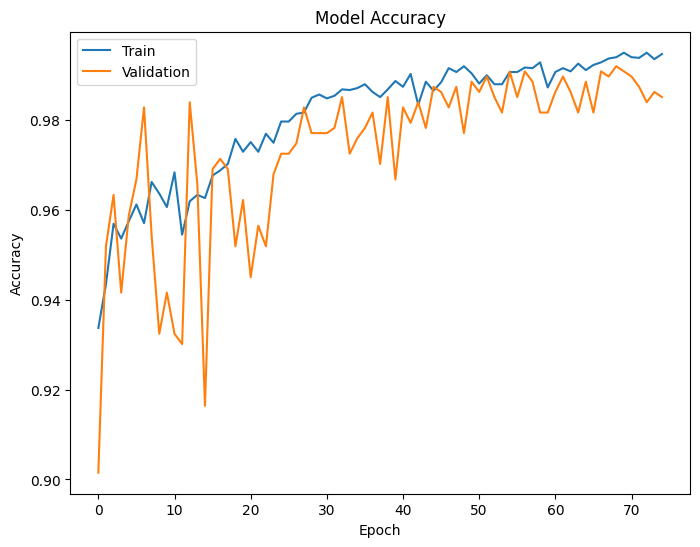

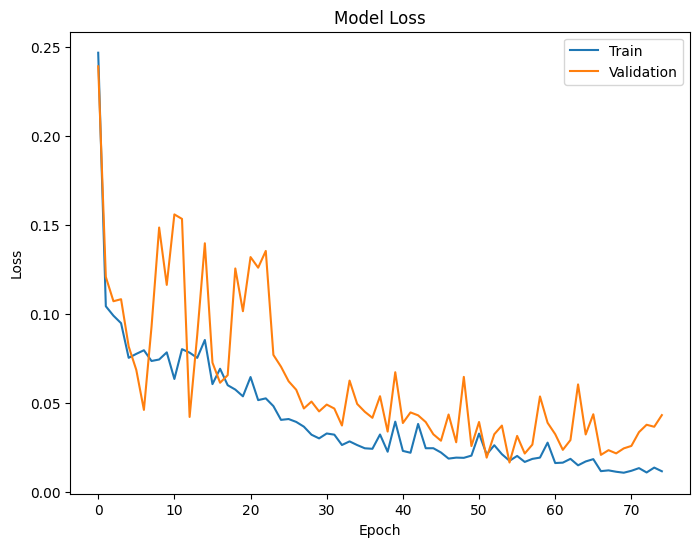

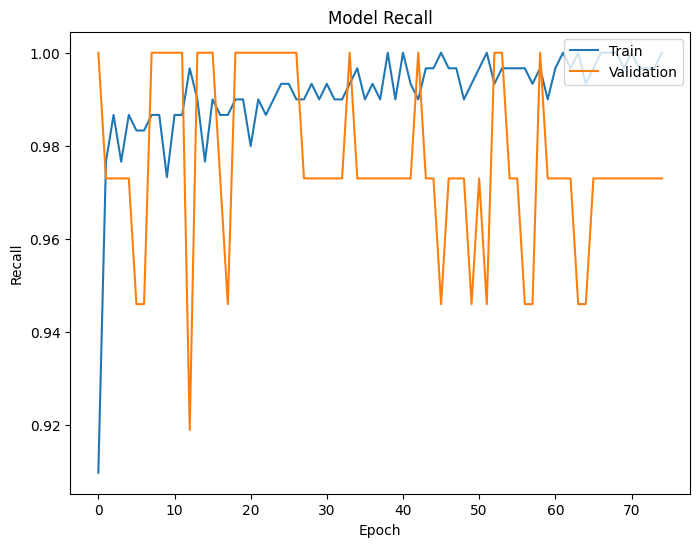

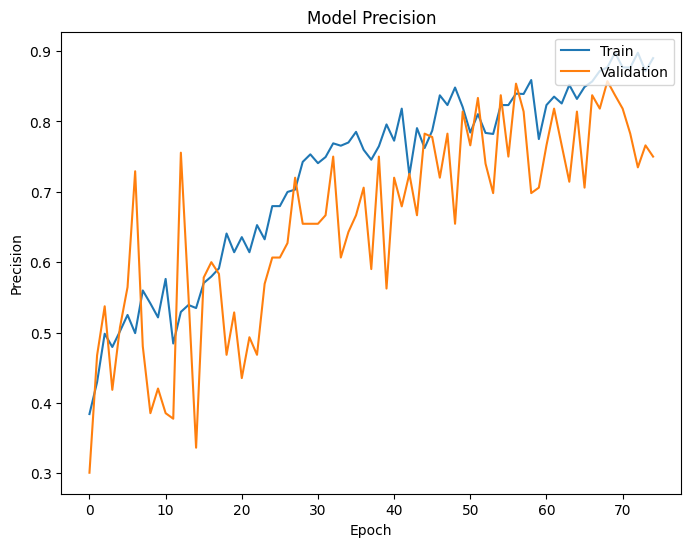

In [21]:
# Plot training history
def plot_history(history):
    # Plot training & validation accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plot training & validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # Plot training & validation recall
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['recall'], label='Train')
    plt.plot(history.history['val_recall'], label='Validation')
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # Plot training & validation precision
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['precision'], label='Train')
    plt.plot(history.history['val_precision'], label='Validation')
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

# Call the function
plot_history(history)

In [22]:
# Get predictions
model = keras.models.load_model(checkpoint_path)

y_pred_prob = model.predict(X_test_selected)
y_pred = np.where(y_pred_prob > 0.5, 1, 0).flatten()

28/28 [==============================] - 0s 1ms/step


In [23]:
# Get metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'Specificity': recall_score(y_test, y_pred, pos_label=0),
    'F1': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_pred_prob),
    'PR-AUC': average_precision_score(y_test, y_pred_prob),
    'Cohen-Kappa': cohen_kappa_score(y_test, y_pred),
    'MCC': matthews_corrcoef(y_test, y_pred),
}

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics, index=['Score']).T
metrics_df

Score
Accuracy     0.991991
Precision    0.897436
Recall       0.921053
Specificity  0.995215
F1           0.909091
ROC-AUC      0.994743
PR-AUC       0.950522
Cohen-Kappa  0.904903
MCC          0.904986

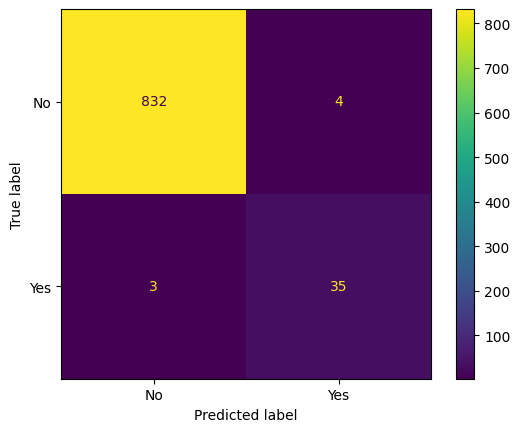

In [24]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot()
plt.show()

# Hyperparameter Tuning

In [25]:
# Function to create the model
def create_model(input_shape, num_units, dropout_rate, activation, optimizer_choice, learning_rate):
    model = keras.Sequential([
        keras.Input(shape=(input_shape,)),
        keras.layers.Dense(num_units[0], activation=activation),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(num_units[1], activation=activation),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(num_units[2], activation=activation),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    # Select optimizer based on optimizer_choice
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'adamw':
        optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    elif optimizer_choice == 'nadam':
        optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer choice")

    model.compile(loss='binary_crossentropy',
                  metrics=['accuracy', keras.metrics.Recall(name='recall'), keras.metrics.Precision(name='precision')],
                  optimizer=optimizer)
    return model

In [26]:
# Objective function
def objective(trial):
    # Suggest values for the hyperparameters
    num_units = [
        trial.suggest_int('num_units_0', 128, 512),
        trial.suggest_int('num_units_1', 128, 512),
        trial.suggest_int('num_units_2', 128, 512)
    ]
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    activation = trial.suggest_categorical('activation', ['relu', 'gelu', 'mish'])
    optimizer_choice = trial.suggest_categorical('optimizer', ['adam', 'adamw', 'nadam'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Create the model with the suggested hyperparameters
    model = create_model(X_train_selected.shape[1], num_units, dropout_rate, activation, optimizer_choice, learning_rate)

    # Define callbacks
    checkpoint_path = 'best_model_trial_{}.tf'.format(trial.number)
    model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=0)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001, mode='min', verbose=0)
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=0)

    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=[model_checkpoint, reduce_lr, early_stopping],
        verbose=0
    )

    # Return the best validation loss
    best_val_loss = min(history.history['val_loss'])
    return best_val_loss

In [27]:
# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print(f"Number of finished trials: {len(study.trials)}")
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-02-28 05:56:16,091] A new study created in memory with name: no-name-1e7f60f6-08a7-4c0e-a181-8f8a55cfac61
[I 2024-02-28 05:57:42,841] Trial 0 finished with value: 0.016118401661515236 and parameters: {'num_units_0': 319, 'num_units_1': 406, 'num_units_2': 141, 'dropout_rate': 0.4565678924903651, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00026547116520143893}. Best is trial 0 with value: 0.016118401661515236.
[I 2024-02-28 05:58:06,360] Trial 1 finished with value: 0.1075173169374466 and parameters: {'num_units_0': 188, 'num_units_1': 277, 'num_units_2': 205, 'dropout_rate': 0.44053903762138014, 'activation': 'gelu', 'optimizer': 'nadam', 'learning_rate': 0.005425209821083868}. Best is trial 0 with value: 0.016118401661515236.
[I 2024-02-28 05:59:45,870] Trial 2 finished with value: 0.09973625838756561 and parameters: {'num_units_0': 208, 'num_units_1': 427, 'num_units_2': 263, 'dropout_rate': 0.21483877423585734, 'activation': 'relu', 'optimizer': 'adam', 'l

Number of finished trials: 30
Best trial:
  Value:  0.0028206361457705498
  Params: 
    num_units_0: 145
    num_units_1: 134
    num_units_2: 506
    dropout_rate: 0.12680826948356516
    activation: mish
    optimizer: nadam
    learning_rate: 0.0016138352830732965


In [28]:
# Best hyperparameters
best_params = study.best_trial.params

# Create a DataFrame
best_params_df = pd.DataFrame(best_params, index=['Value']).T
best_params_df

Value
num_units_0         145
num_units_1         134
num_units_2         506
dropout_rate   0.126808
activation         mish
optimizer         nadam
learning_rate  0.001614

In [29]:
# Extracting the best hyperparameters
num_units_best = [best_params['num_units_0'], best_params['num_units_1'], best_params['num_units_2']]
dropout_rate_best = best_params['dropout_rate']
activation_best = best_params['activation']
optimizer_choice_best = best_params['optimizer']
learning_rate_best = best_params['learning_rate']

In [30]:
# Rebuild the model with the best hyperparameters
best_model = create_model(X_train_selected.shape[1], num_units_best, dropout_rate_best, activation_best, optimizer_choice_best, learning_rate_best)

# Recompile the model
if optimizer_choice_best == 'adam':
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate_best)
elif optimizer_choice_best == 'adamw':
    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate_best)
elif optimizer_choice_best == 'nadam':
    optimizer = keras.optimizers.Nadam(learning_rate=learning_rate_best)

best_model.compile(optimizer=optimizer,
                   loss='binary_crossentropy',
                   metrics=['accuracy', keras.metrics.Recall(name='recall'), keras.metrics.Precision(name='precision')])

# Define callbacks
model_checkpoint_best = keras.callbacks.ModelCheckpoint('best_model_final.tf', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr_best = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001, mode='min', verbose=1)
early_stopping_best = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1)

# Train the best model
history_best = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[model_checkpoint_best, reduce_lr_best, early_stopping_best],
    verbose=1
)

Epoch 1/100
209/219 [===========================>..] - ETA: 0s - loss: 0.2167 - accuracy: 0.9224 - recall: 0.9512 - precision: 0.3509
Epoch 1: val_loss improved from inf to 0.16739, saving model to best_model_final.tf
219/219 [==============================] - 4s 9ms/step - loss: 0.2129 - accuracy: 0.9220 - recall: 0.9532 - precision: 0.3493 - val_loss: 0.1674 - val_accuracy: 0.9107 - val_recall: 1.0000 - val_precision: 0.3217 - lr: 0.0016
Epoch 2/100
207/219 [===========================>..] - ETA: 0s - loss: 0.1024 - accuracy: 0.9508 - recall: 0.9791 - precision: 0.4676
Epoch 2: val_loss improved from 0.16739 to 0.15684, saving model to best_model_final.tf
219/219 [==============================] - 2s 8ms/step - loss: 0.1000 - accuracy: 0.9515 - recall: 0.9799 - precision: 0.4681 - val_loss: 0.1568 - val_accuracy: 0.9370 - val_recall: 1.0000 - val_precision: 0.4022 - lr: 0.0016
Epoch 3/100
207/219 [===========================>..] - ETA: 0s - loss: 0.0867 - accuracy: 0.9546 - recall: 0

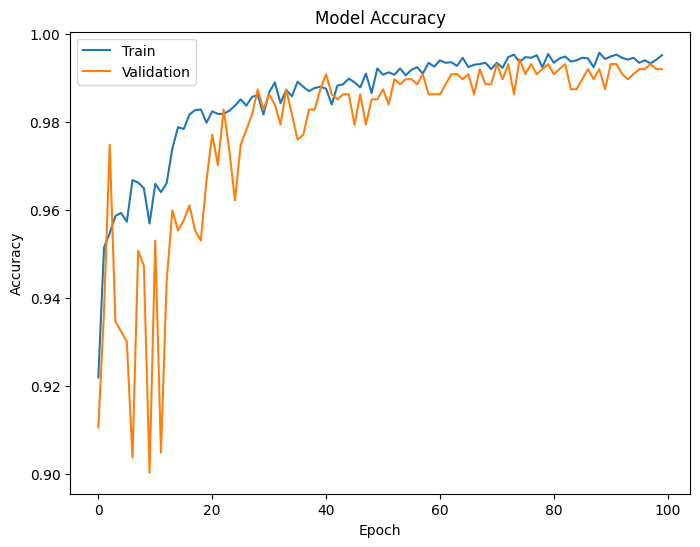

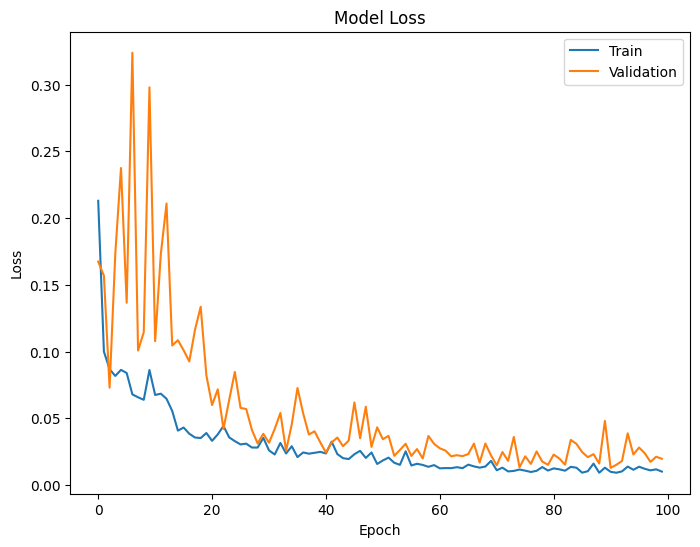

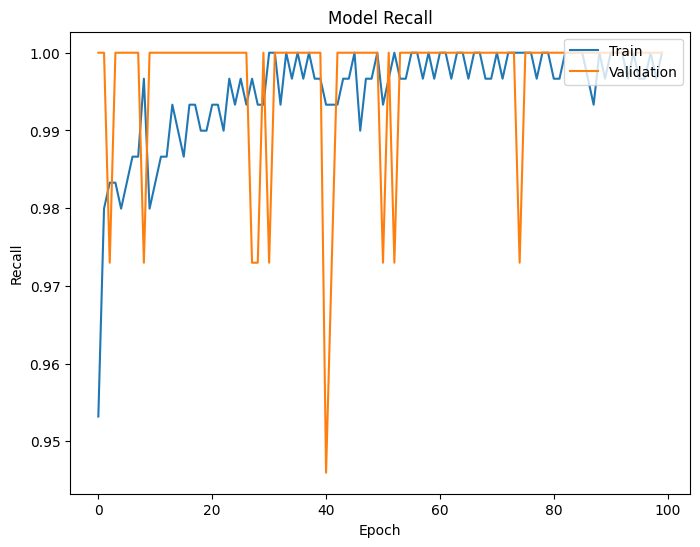

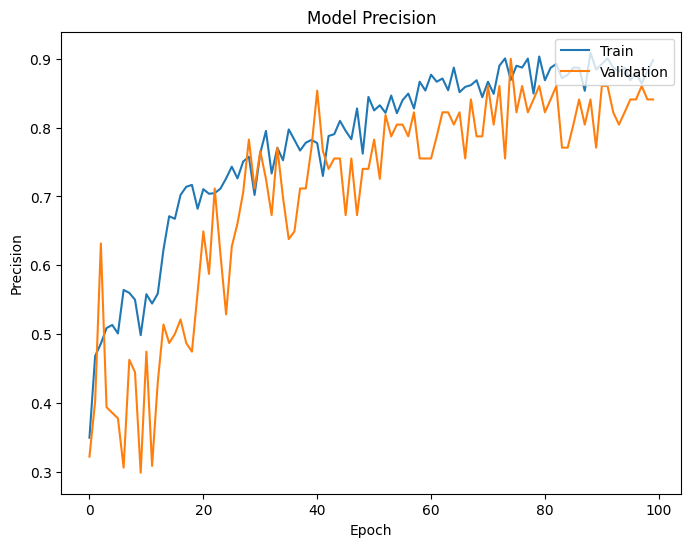

In [31]:
# Plot training history
plot_history(history_best)

# Final Evaluation

In [32]:
# Load the best model
best_model = keras.models.load_model('best_model_final.tf')

In [33]:
# Function to get metrics
def get_metrics_dataframe(model, X_test, y_test, threshold=0.5):
    # Predict
    y_pred_prob = model.predict(X_test_selected)
    y_pred = np.where(y_pred_prob > threshold, 1, 0).flatten()

    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Specificity': recall_score(y_test, y_pred, pos_label=0),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_prob),
        'PR-AUC': average_precision_score(y_test, y_pred_prob),
        'Cohen-Kappa': cohen_kappa_score(y_test, y_pred),
        'MCC': matthews_corrcoef(y_test, y_pred),
    }

    # Convert metrics to DataFrame
    metrics_df = pd.DataFrame(metrics, index=['Score']).T
    return metrics_df

# Call the function
metrics_df = get_metrics_dataframe(best_model, X_test=X_test_selected, y_test=y_test)
metrics_df

28/28 [==============================] - 0s 1ms/step


Score
Accuracy     0.988558
Precision    0.850000
Recall       0.894737
Specificity  0.992823
F1           0.871795
ROC-AUC      0.994051
PR-AUC       0.955685
Cohen-Kappa  0.865811
MCC          0.866123

28/28 [==============================] - 0s 1ms/step


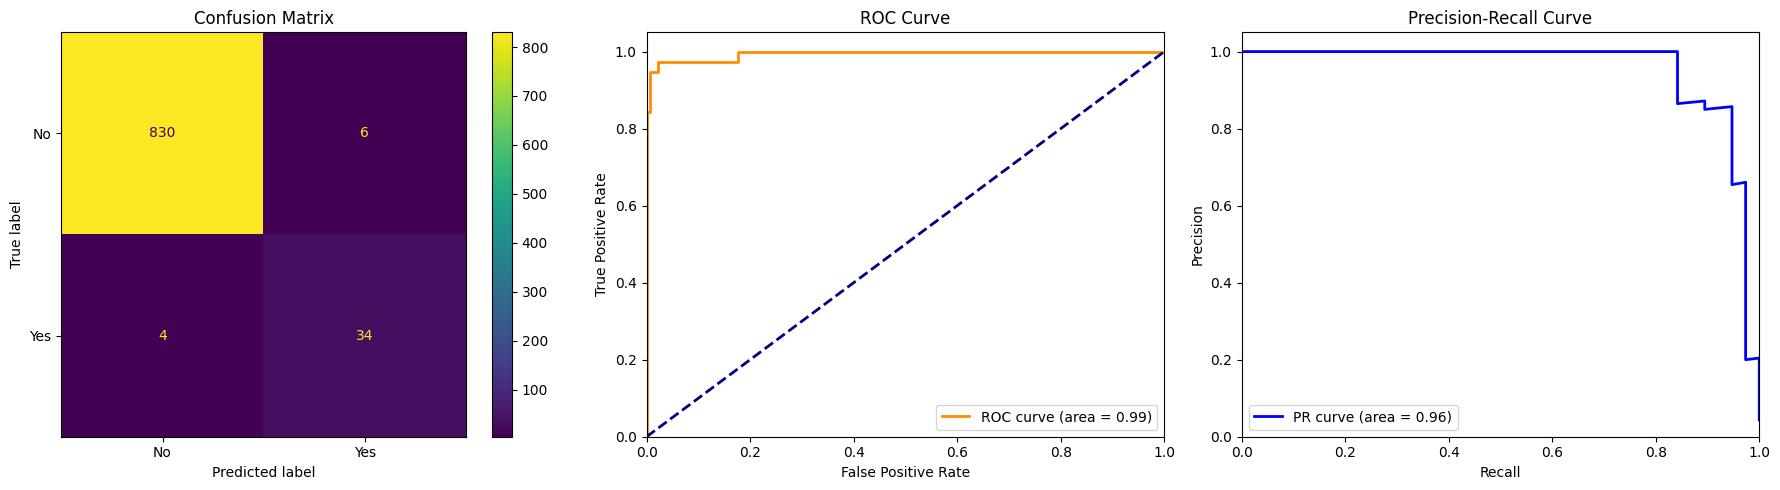

In [34]:
# Function to visualize model performance
def get_visualizations(model, X_test, y_test, threshold=0.5):
    # Predict
    y_pred_prob = model.predict(X_test_selected).flatten()
    y_pred = np.where(y_pred_prob > threshold, 1, 0)

    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(ax=ax[0])
    ax[0].set_title('Confusion Matrix')

    # ROC-AUC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('ROC Curve')
    ax[1].legend(loc="lower right")

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = average_precision_score(y_test, y_pred_prob)
    ax[2].plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    ax[2].set_xlabel('Recall')
    ax[2].set_ylabel('Precision')
    ax[2].set_ylim([0.0, 1.05])
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_title('Precision-Recall Curve')
    ax[2].legend(loc="lower left")

    plt.tight_layout()
    plt.show()

# Call the function
get_visualizations(best_model, X_test=X_test_selected, y_test=y_test)

# Saving Objects

In [35]:
# Save the best tuned model
best_model.save('best_model_final.tf')

In [36]:
# Zip the saved model directory
shutil.make_archive('/content/best_model_final', 'zip', '/content/best_model_final.tf')

# Download it using files.download() method
from google.colab import files
files.download('/content/best_model_final.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
# Save the scaler
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [38]:
# Function to download one random clip per class
def download_random_audio_clips(dataset, destination_folder):
    # Ensure the destination folder exists
    os.makedirs(destination_folder, exist_ok=True)

    # Initialize a dictionary to hold clip IDs for each class
    clips_per_class = defaultdict(list)
    for clip_id in dataset.clip_ids:
        clip = dataset.clip(clip_id)
        clips_per_class[clip.class_label].append(clip_id)

    # Select a random clip ID for each class label
    selected_clip_ids = {class_label: random.choice(clip_ids) for class_label, clip_ids in clips_per_class.items()}

    # Download audio for each selected clip
    for class_label, clip_id in selected_clip_ids.items():
        clip = dataset.clip(clip_id)

        # Construct the destination file path
        destination_file_path = os.path.join(destination_folder, f"{clip_id}_{class_label}.wav")

        # Copy the file to the destination folder
        shutil.copy(clip.audio_path, destination_file_path)
        print(f"Downloaded {class_label} clip to {destination_file_path}")

# Specify the destination folder
destination_folder = '/content'

# Call the function
download_random_audio_clips(dataset=dataset, destination_folder=destination_folder)

Downloaded children_playing clip to /content/207214-2-0-54_children_playing.wav
Downloaded gun_shot clip to /content/148166-6-0-0_gun_shot.wav
Downloaded air_conditioner clip to /content/177726-0-0-6_air_conditioner.wav
Downloaded jackhammer clip to /content/104998-7-8-17_jackhammer.wav
Downloaded drilling clip to /content/168037-4-12-0_drilling.wav
Downloaded engine_idling clip to /content/15544-5-0-13_engine_idling.wav
Downloaded dog_bark clip to /content/32318-3-0-0_dog_bark.wav
Downloaded siren clip to /content/203913-8-0-8_siren.wav
Downloaded street_music clip to /content/149254-9-0-30_street_music.wav
Downloaded car_horn clip to /content/179865-1-0-0_car_horn.wav


# Threshold Analysis

In [54]:
# Function to find the optimal threshold for the classifier
def find_optimal_threshold(model, X_test, y_test, min_recall=0.92):
    # Predict probabilities
    y_pred_prob = model.predict(X_test).flatten()

    # Define a range of thresholds
    thresholds = np.linspace(0, 1, 101)

    # Store the best threshold and its score
    best_threshold = 0.5
    best_score = 0

    for threshold in thresholds:
        # Convert probabilities to predictions based on threshold
        y_pred = np.where(y_pred_prob > threshold, 1, 0)

        # Calculate the F1 and recall scores
        score = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        # Update the best threshold if the score is better and recall meets the minimum requirement
        if score > best_score and recall >= min_recall:
            best_score = score
            best_threshold = threshold

    return best_threshold, best_score

# Call the function
optimal_threshold, optimal_score = find_optimal_threshold(best_model, X_test_selected, y_test, min_recall=0.92)
print(f"Optimal Threshold: {optimal_threshold}, Optimal Score: {optimal_score}")

28/28 [==============================] - 0s 2ms/step
Optimal Threshold: 0.11, Optimal Score: 0.9


28/28 [==============================] - 0s 1ms/step


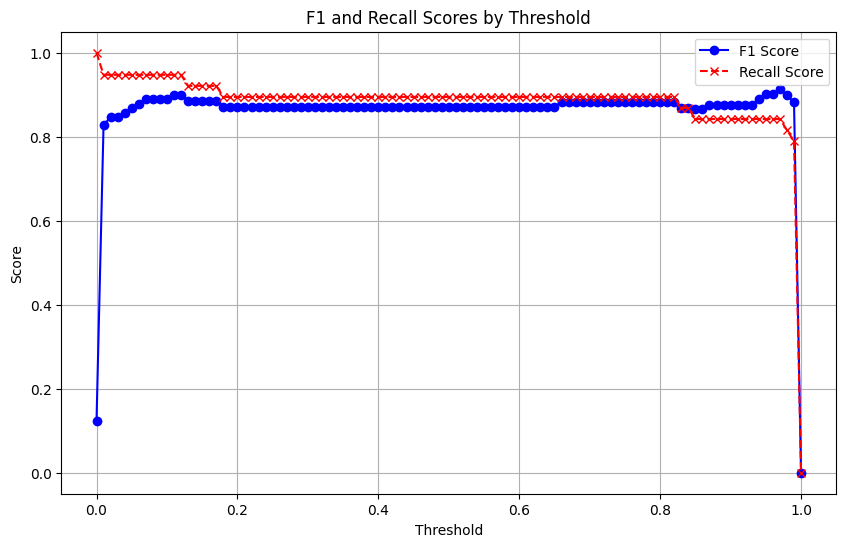

Optimal Threshold: 0.11, Optimal Score: 0.9


In [56]:
# Function to plot the scores for each threshold value
def plot_optimal_threshold(model, X_test, y_test, min_recall=0.92):
    # Predict probabilities
    y_pred_prob = model.predict(X_test).flatten()

    # Define a range of thresholds
    thresholds = np.linspace(0, 1, 101)

    # Initialize lists to store scores
    f1_scores = []
    recall_scores = []

    for threshold in thresholds:
        # Convert probabilities to predictions based on threshold
        y_pred = np.where(y_pred_prob > threshold, 1, 0)

        # Calculate the F1 and recall scores and append them to their respective lists
        f1_scores.append(f1_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))

    # Filter scores where recall >= minimum recall requirement
    valid_scores = [(f1, threshold) for f1, recall, threshold in zip(f1_scores, recall_scores, thresholds) if recall >= min_recall]

    if not valid_scores:
        print("No thresholds meet the minimum recall requirement.")
        return

    # Unpack the scores and thresholds
    valid_f1_scores, valid_thresholds = zip(*valid_scores)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, label='F1 Score', marker='o', linestyle='-', color='b')
    plt.plot(thresholds, recall_scores, label='Recall Score', marker='x', linestyle='--', color='r')
    plt.title('F1 and Recall Scores by Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Find the optimal threshold among valid ones based on F1 score
    best_index = np.argmax(valid_f1_scores)
    best_threshold = valid_thresholds[best_index]
    best_score = valid_f1_scores[best_index]

    print(f"Optimal Threshold: {best_threshold}, Optimal Score: {best_score}")

# Call the function
plot_optimal_threshold(best_model, X_test_selected, y_test)

In [57]:
# Get new metrics
new_metrics_df = get_metrics_dataframe(best_model, X_test=X_test_selected, y_test=y_test, threshold=optimal_threshold)
new_metrics_df

28/28 [==============================] - 0s 2ms/step


Score
Accuracy     0.990847
Precision    0.857143
Recall       0.947368
Specificity  0.992823
F1           0.900000
ROC-AUC      0.994051
PR-AUC       0.955685
Cohen-Kappa  0.895216
MCC          0.896448

28/28 [==============================] - 0s 1ms/step


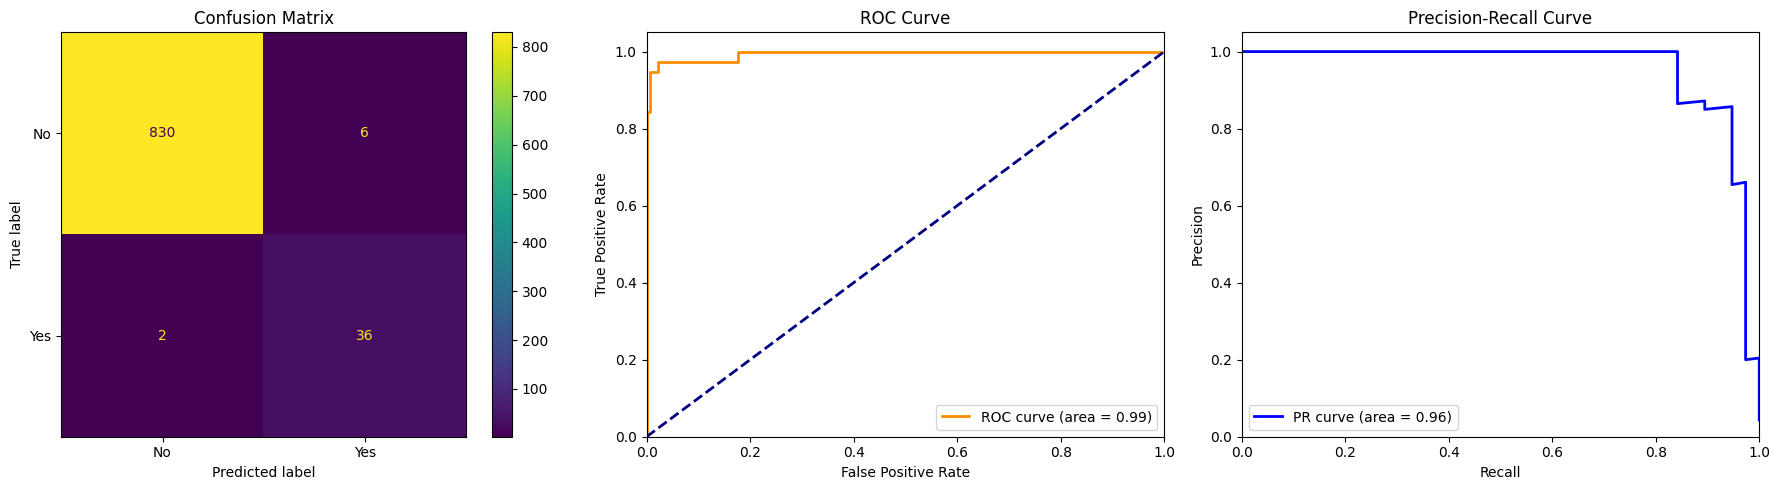

In [58]:
# Get new visualizations
get_visualizations(best_model, X_test=X_test_selected, y_test=y_test, threshold=optimal_threshold)